# Hack IMDb Rating
## Introduction

Welcome to the Movie Data Analysis Project! This notebook is designed to take you through a comprehensive journey of exploring, analyzing, and understanding the intricate world of movies. Our primary goal is to uncover the factors that influence a movie's success, focusing on aspects such as revenue generation and IMDB ratings.

This notebook is structured to guide you through each step of the process, from data loading and cleaning to in-depth analysis. So, let's dive in and explore the fascinating world of movies through the lens of data science!



## Research Questions

1. *What factors contribute to a movie's success, and how do they interplay?*
   - Language and its role in reaching a wider audience
   - Impact of film duration
   - The influence of release timing on ratings
   - How movie genres have evolved over time
   - The correlation between box office success and ratings
   - Geographical patterns in movie ratings 
   

2. *How does diversity and representation influence movie ratings?*
   - Gender diversity within film casts
   - The effect of ethnic diversity on a film's reception

3. *What impact do actors have on a film's rating?*
   - The role of actor types and their influence
   - Effects of actor collaborations on film ratings

4. *Does the portrayal of characters (protagonists) affect ratings?*

5. *Is there a link between real-world events and a movie's success?*
   - Analysis of movie plots in relation to real-world events
   - Comparative study of event-based movies against other genres
   - Exploration of propaganda films and their ratings impact

6. *Can we develop a predictive model for movie ratings?*
   - Utilizing identified key parameters for prediction
   - Implementing sentiment analysis of movie reviews and comments

## Additional Dataset

To enrich our analysis, we will add the IMDb ratings dataset.

By addressing these questions with  analytical methods, we aim to offer a comprehensive understanding of the factors influencing IMDb ratings.


In [1]:
#imports
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
from SPARQLWrapper import SPARQLWrapper, JSON

import json


sns.set_style("whitegrid")
pd.options.mode.chained_assignment = None  # default='warn', Mutes warnings when copying a slice from a DataFrame.

---
# Data Pipeline


## Dataset Overview

### CMU Movie Summary Corpus

We begin by analysing data from the CMU Movie Summary Corpus. This collection includes several files:

- *character.metadata.csv:* Contains metadata information about movie characters.
- *movie.metadata.tsv:* Provides movie metadata such as title, genre, and release year.
- *name.cluster.txt:* Offers information related to name clustering.
- *plot_summaries.txt:* Contains summaries of movie plots.
- *tvtropes.cluster.txt:* Includes data on TV Tropes clustering.

### IMDb Rating Dataset

Our analysis integrates the IMDb rating dataset taken from [IMDb Datasets](https://datasets.imdbws.com). This dataset comprises two CSV files:

- *rating_id.csv:* Contains IMDb rating data.
- *name_id.csv:* Includes additional information about the movies (name, type, ...).

### Events Dataset

Supplementary data, generated by ChatGPT, is included in the analysis. This dataset captures the most significant events from 1820 to 2014 and is created using the code found in `generate_events.py`.

## Oscar Dataset

This dataset is a collection of data from The Academy Awards Database, containing the winners and nominees of the Oscars from 1927 to 2023. it is taken from [kaggle Oscars Dataset](https://www.kaggle.com/datasets/unanimad/the-oscar-award) 


#### 1. Loading CMU Data

In [2]:
#read tsv file and add headers
movie_metadata_df = pd.read_csv('data/CMU_DATA/movie.metadata.tsv', sep='\t', header=None, 
                names=['wiki_movie_id', 
                        'freebase_movie_id', 
                        'movie_name', 
                        'movie_release_date', 
                        'movie_box_office_revenue', 
                        'movie_runtime', 
                        'movie_languages', 
                        'movie_countries', 
                        'movie_genres'])

#changing the values of outliers
movie_metadata_df.loc[movie_metadata_df['movie_name'] == 'Zero Tolerance', 'movie_runtime'] = 88
movie_metadata_df.loc[movie_metadata_df['movie_name'] == 'Hunting Season', 'movie_release_date'] = '2010-12-02'

#add realase_year 
movie_metadata_df['startYear']= movie_metadata_df['movie_release_date'].str[:4]

#change movie_release_date to pandas datetime
movie_metadata_df['movie_release_date'] = pd.to_datetime(movie_metadata_df['movie_release_date'], format='%Y-%m-%d', errors='coerce')
movie_metadata_df.head()


,wiki_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,startYear
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",2000
2,28463795,/m/0crgdbh,Brun bitter,NaT,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",1988
3,9363483,/m/0285_cd,White Of The Eye,NaT,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",1987
4,261236,/m/01mrr1,A Woman in Flames,NaT,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",1983


In [3]:
#loading the plot summaries dataset and add headers
plot_summaries_df = pd.read_csv('data/CMU_DATA/plot_summaries.txt', sep='\t', header=None, 
                names=['wiki_movie_id', 
                        'plot_summary'])
plot_summaries_df.head()

,wiki_movie_id,plot_summary
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


In [4]:
#read text file and add headers, name.clusters.txt
name_clusters_df = pd.read_csv('data/CMU_DATA/name.clusters.txt', sep='\t', header=None, 
                names=['character_name', 
                        'freebase_character_actor_map_id'])
name_clusters_df.head()

,character_name,freebase_character_actor_map_id
0,Stuart Little,/m/0k3w9c
1,Stuart Little,/m/0k3wcx
2,Stuart Little,/m/0k3wbn
3,John Doe,/m/0jyg35
4,John Doe,/m/0k2_zn


In [5]:
#read text file and add headers, name.clusters.txt
name_clusters_df = pd.read_csv('data/CMU_DATA/name.clusters.txt', sep='\t', header=None, 
                names=['character_name', 
                        'freebase_character_actor_map_id'])
name_clusters_df.head()

,character_name,freebase_character_actor_map_id
0,Stuart Little,/m/0k3w9c
1,Stuart Little,/m/0k3wcx
2,Stuart Little,/m/0k3wbn
3,John Doe,/m/0jyg35
4,John Doe,/m/0k2_zn


In [6]:
#read text file and add headers
character_metadata_df = pd.read_csv('data/CMU_DATA/character.metadata.tsv', sep='\t', header=None, 
                names=['wiki_movie_id',
                        'freebase_movie_id',
                        'movie_release_date',
                        'character_name',
                        'actor_date_of_birth',
                        'actor_gender',
                        'actor_height',
                        'actor_ethnicity',
                        'actor_name',
                        'actor_age_at_movie_release',
                        'freebase_character_actor_map_id',
                        'freebase_character_id',
                        'freebase_actor_id'])
character_metadata_df.head()

,wiki_movie_id,freebase_movie_id,movie_release_date,character_name,actor_date_of_birth,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_movie_release,freebase_character_actor_map_id,freebase_character_id,freebase_actor_id
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [7]:
#read text file and add headers
tvtropes_clusters_df = pd.read_csv('data/CMU_DATA/tvtropes.clusters.txt', sep='\t', header=None, names=['character_type', 'data_dict'])
#transform second column to columns
tvtropes_clusters_df['data_dict'] = tvtropes_clusters_df['data_dict'].apply(json.loads)
tvtropes_clusters_df = pd.concat([tvtropes_clusters_df.drop(['data_dict'], axis=1), tvtropes_clusters_df['data_dict'].apply(pd.Series)], axis=1)
#rename columns
tvtropes_clusters_df.columns = ['character_type', 'character_name', 'movie_name', 'freebase_character_actor_map_id', 'actor_name']
tvtropes_clusters_df.head()

,character_type,character_name,movie_name,freebase_character_actor_map_id,actor_name
0,absent_minded_professor,Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams
1,absent_minded_professor,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane
2,absent_minded_professor,Dr. Reinhardt Lane,The Shadow,/m/0k6fkc,Ian McKellen
3,absent_minded_professor,Dr. Harold Medford,Them!,/m/0k6_br,Edmund Gwenn
4,absent_minded_professor,Daniel Jackson,Stargate,/m/0k3rhh,James Spader


#### 2. Loading IMDB Data

In [8]:
#load IMDB reviews
rating_id_df = pd.read_csv('data/IMDB_DATA/rating_id.tsv',  sep='\t')
name_id_df = pd.read_csv('data/IMDB_DATA/name_id.tsv',  sep='\t')
rating_df = pd.merge(rating_id_df, name_id_df, on='tconst')

#drop unnecessary columns 
rating_df.drop(['originalTitle','isAdult','endYear','runtimeMinutes','genres'], axis=1, inplace=True)
rating_df.head()

/var/folders/sk/c4f8zf_14lg_474m69nfgc7m0000gn/T/ipykernel_62206/75358026.py:3: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  name_id_df = pd.read_csv('data/IMDB_DATA/name_id.tsv',  sep='\t')


,tconst,averageRating,numVotes,titleType,movie_name,startYear
0,tt0000001,5.7,2007,short,Carmencita,1894
1,tt0000002,5.8,269,short,Le clown et ses chiens,1892
2,tt0000003,6.5,1911,short,Pauvre Pierrot,1892
3,tt0000004,5.5,178,short,Un bon bock,1892
4,tt0000005,6.2,2692,short,Blacksmith Scene,1893


#### 3. Loading Events Data

In [9]:
#loading the events dataset 
events = pd.read_csv('data/GENERATED_DATA/events.csv')
events.head()

,Year,Event Name,Event Description,Event Location,Event Category
0,1820,Missouri Compromise,The U.S. Congress passes the Missouri Compromi...,USA,Political Events
1,1820,Antarctic Discovery,The British explorer James Weddell discovers t...,GBR,Science and health advancement
2,1820,The Cato Street Conspiracy,An attempt to murder all the British cabinet m...,GBR,Political Events
3,1820,Death of George III,King George III of the United Kingdom passes a...,GBR,Political Events
4,1820,Establishment of Liberia,American Colonization Society purchases a smal...,LBR,Social Movements


#### 4. Merging The Movie Metadata With The IMDb Ratings

In [10]:
#merging the movie metadata with the rating data on movie name and release year
movies_metadata_ratings = pd.merge(movie_metadata_df, rating_df,  on=['movie_name', 'startYear'])
movies_metadata_ratings.head()

,wiki_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,startYear,tconst,averageRating,numVotes,titleType
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001,tt0228333,4.9,56920,movie
1,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001,tt0594845,7.6,20,tvEpisode
2,28463795,/m/0crgdbh,Brun bitter,NaT,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",1988,tt0094806,5.6,40,movie
3,261236,/m/01mrr1,A Woman in Flames,NaT,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",1983,tt0083949,5.9,623,movie
4,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",1913,tt0002894,6.8,17,short


#### 5. Cleaning The Data

After inspecting of the plot_summary file in the CMU dataset, we noticed that some movie plots contains undesired words such as ({long plot}, {plot}...). These outliers can degrade our plot analysis so we proceeded to remove them. 

In [11]:
#remove any {{ }} from the plot summary text
plot_summaries_df['plot_summary'] = plot_summaries_df['plot_summary'].str.replace(r'\{\{.*?\}\}', '', regex=True)

We noticed the IMDb dataset included other types of movies, those movies are also in some cases present in the CMU dataset. Since our analysis focuses on movies we opted to only keep 'movie' tittle type movies. 

In [12]:
# printing the types of the merged data 
movies_metadata_ratings['titleType'].unique()

array(['movie', 'tvEpisode', 'short', 'tvMovie', 'video', 'tvSeries',
       'videoGame', 'tvMiniSeries', 'tvSpecial', 'tvShort'], dtype=object)

In [13]:
# keeping only movies, delete tv episodes, tv movies, video games, etc.
movies_metadata_ratings = movies_metadata_ratings[movies_metadata_ratings['titleType']=='movie']
movies_metadata_ratings.head()

,wiki_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,startYear,tconst,averageRating,numVotes,titleType
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001,tt0228333,4.9,56920,movie
2,28463795,/m/0crgdbh,Brun bitter,NaT,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",1988,tt0094806,5.6,40,movie
3,261236,/m/01mrr1,A Woman in Flames,NaT,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",1983,tt0083949,5.9,623,movie
5,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",1938,tt0029852,6.8,2268,movie
6,175026,/m/017n1p,Sarah and Son,NaT,NaN,86.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama"", ""/m/01g6gs"": ""Black-an...",1930,tt0021335,5.4,300,movie


we noticed that the IMDb dataset contains movie ratings that have few ratings so we thought that these ratings could be biased so we removed the movies that have less than 200 votes

In [14]:
# only keep the movies with more than 200 votes on imdb ratings
movies_metadata_ratings = movies_metadata_ratings[movies_metadata_ratings['numVotes']>200]
movies_metadata_ratings.shape

(27739, 14)

Now we will filter the other datasets so that they are consistant

In [15]:
#keep movie_metadata_df only with movies that have ratings
movie_metadata_df = movie_metadata_df[movie_metadata_df['freebase_movie_id'].isin(movies_metadata_ratings['freebase_movie_id'])]
movie_metadata_df.shape

(27655, 10)

In [16]:
#keep the summaries of the selected movies 
plot_summaries_df = plot_summaries_df[plot_summaries_df['wiki_movie_id'].isin(movie_metadata_df['wiki_movie_id'])]
plot_summaries_df.shape

(20161, 2)

In [17]:
#keep movie_metadata_df only with movies that have summaries
movie_metadata_df = movie_metadata_df[movie_metadata_df['wiki_movie_id'].isin(plot_summaries_df['wiki_movie_id'])]
movie_metadata_df.shape

(20161, 10)

In [18]:
#keep movies_metadata_ratings only with movies that have summaries
movies_metadata_ratings = movies_metadata_ratings[movies_metadata_ratings['wiki_movie_id'].isin(plot_summaries_df['wiki_movie_id'])]
movies_metadata_ratings.shape

(20216, 14)

In [19]:
#keep the character_metadata_df only with movies that have summaries and ratings
character_metadata_df = character_metadata_df[character_metadata_df['wiki_movie_id'].isin(movie_metadata_df['wiki_movie_id'])]
character_metadata_df.shape

(192540, 13)

In [20]:
#keep the tvtropes_clusters_df only with movies that have summaries and ratings
tvtropes_clusters_df = tvtropes_clusters_df[tvtropes_clusters_df['freebase_character_actor_map_id'].isin(character_metadata_df['freebase_character_actor_map_id'])]
tvtropes_clusters_df.shape

(453, 5)

---
# Data Analysis

## 1- effect of language 

In [33]:
languages_df_with_ratings = movies_metadata_ratings[['wiki_movie_id','movie_name', 'movie_languages', 'averageRating']]

languages_df_with_ratings['movie_languages'] = languages_df_with_ratings['movie_languages'].apply(lambda x: list(json.loads(x).values()))

# Explode the 'movie_languages' column
languages_df_with_ratings = languages_df_with_ratings.explode('movie_languages')

# Rename the column and select only the required columns
languages_df_with_ratings = languages_df_with_ratings.rename(columns={'movie_languages': 'language_name'})[['wiki_movie_id','movie_name', 'language_name', 'averageRating']]

languages_df_with_ratings = languages_df_with_ratings[languages_df_with_ratings['language_name'].notna()]
languages_df_with_ratings.reset_index(drop=True, inplace=True)
languages_df_with_ratings


,wiki_movie_id,movie_name,language_name,averageRating
0,975900,Ghosts of Mars,English Language,4.9
1,261236,A Woman in Flames,German Language,5.9
2,171005,Henry V,English Language,7.5
3,77856,Mary Poppins,English Language,7.8
4,156558,Baby Boy,English Language,6.4
...,...,...,...,...
24334,1918494,State and Main,English Language,6.7
24335,3868432,Into the Mirror,Korean Language,6.4
24336,15394941,Gopi Kishan,Hindi Language,5.8
24337,23851782,The Ghost Train,English Language,6.2


In [34]:
reduced_languages_df_with_ratings = languages_df_with_ratings.head(2000)
#save to csv
reduced_languages_df_with_ratings.to_csv('erase_this_language.csv', index=False)

In [ ]:
#create a dataframe with only the movie countries
movie_countries_df = movie_metadata_df[['freebase_movie_id', 'movie_countries']]
movie_countries_df['movie_countries'] = movie_metadata_df['movie_countries'].apply(json.loads)
movie_countries_df = movie_countries_df.explode('movie_countries')
movie_countries_df.rename(columns={'movie_countries':'freebase_countries_id'}, inplace=True)
movie_countries_df.head(10)

In [ ]:
#create a dataframe with only the movie genres
movie_genres_df = movie_metadata_df[['freebase_movie_id', 'movie_genres']]
movie_genres_df['movie_genres'] = movie_metadata_df['movie_genres'].apply(json.loads)
movie_genres_df = movie_genres_df.explode('movie_genres')
movie_genres_df.rename(columns={'movie_genres':'freebase_genres_id'}, inplace=True)
movie_genres_df.head(10)

In [ ]:
#5 biggest box office movies
movie_metadata_df.sort_values(by=['movie_box_office_revenue'], ascending=False).head(5)

In [ ]:
#plot box office revenue with a log scale
plt.figure(figsize=(10, 6))
plt.hist(movie_metadata_df['movie_box_office_revenue'], bins=100, log=True)
plt.xlabel('Box Office Revenue')
plt.ylabel('Number of Movies')
plt.title('Box Office Revenue Histogram')
plt.show()

In [ ]:
#aggregate movie revenue by year
movie_revenue_by_year = movie_metadata_df.groupby(pd.Grouper(key='movie_release_date', freq='Y'))['movie_box_office_revenue'].sum()
#aggregate number of movies by year ignoring movies with no revenue
movie_with_revenue = movie_metadata_df[movie_metadata_df['movie_box_office_revenue'] > 0]
movie_by_year = movie_with_revenue.groupby(pd.Grouper(key='movie_release_date', freq='Y'))['movie_box_office_revenue'].count()
#plot movie revenue by year
plt.figure(figsize=(10,5))
plt.plot(movie_revenue_by_year.loc['1975':'2012'], color='blue', label='Revenue')
plt.xlabel('Year')
plt.ylabel('Revenue')
plt.legend(loc='upper left', bbox_to_anchor=(0, 0.92))
plt.twinx()
plt.plot(movie_by_year.loc['1975':'2012'], color='red', label='Number of Movies')
plt.ylabel('Number of Movies')
plt.title('Movie Revenue and Number of Movies by Year')
plt.legend(loc='upper left')
plt.show()

In [ ]:
#movies per month ignoring movies with no revenue
movie_per_month = movie_with_revenue.groupby(movie_with_revenue['movie_release_date'].dt.strftime('%m')).count()['freebase_movie_id']
movie_per_month.index = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 
                                'November', 'December']
#plot a histogram of the months with the most movies released
plt.figure(figsize=(12, 6))
plt.plot(movie_per_month)
plt.xlabel('Month')
plt.ylabel('Number of Movies')
plt.title('Movie Release Month Histogram')
plt.show()

In [ ]:
#aggregate movie revenue by month in 12 bins
movie_revenue_by_month = movie_metadata_df.groupby(movie_metadata_df['movie_release_date'].dt.strftime('%m'))['movie_box_office_revenue'].sum()
#change index to month names
movie_revenue_by_month.index = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 
                                'November', 'December']
#plot histogram of movie revenue by month
plt.figure(figsize=(12, 6))
plt.plot(movie_revenue_by_month)
plt.xlabel('Month')
plt.ylabel('Revenue for Month')
plt.title('Movie Release Month Revenue Histogram')
plt.show()

In [ ]:
#plot month that are the most profitable
plt.figure(figsize=(12, 6))
plt.plot(movie_revenue_by_month/movie_per_month)
plt.xlabel('Month')
plt.ylabel('Revenue per film')
plt.title('Movie Release Month Revenue Histogram')
plt.show()

In [ ]:
#5 longest movies
movie_metadata_df.sort_values(by=['movie_runtime'], ascending=False).head(5)

In [ ]:
#5 longest movies excluding movies longer than 240 minutes (4 hours)
movie_metadata_df[movie_metadata_df['movie_runtime'] < 240].sort_values(by=['movie_runtime'], ascending=False).head(5)

In [ ]:
#plot runtime distribution with median and mean
plt.hist(movie_metadata_df[movie_metadata_df['movie_runtime'] < 240]['movie_runtime'], bins=100)
plt.axvline(movie_metadata_df['movie_runtime'].median(), color='red', linestyle='dashed', linewidth=1)
plt.text(movie_metadata_df['movie_runtime'].median() + 5, 4300, 'Median: ' + str(int(movie_metadata_df['movie_runtime'].median()/60)) + 'h ' + str(int(movie_metadata_df['movie_runtime'].median()%60)) + 'm')
plt.axvline(movie_metadata_df['movie_runtime'].mean(), color='green', linestyle='dashed', linewidth=1)
plt.text(movie_metadata_df['movie_runtime'].mean() + 5, 4500, 'Mean: ' + str(int(movie_metadata_df['movie_runtime'].mean()/60)) + 'h ' + str(int(movie_metadata_df['movie_runtime'].mean()%60)) + 'm')
plt.xlabel('Runtime (minutes)')
plt.ylabel('Number of Movies')
plt.title('Runtime Distribution')
plt.show()

In [ ]:
#5 shortest movies
movie_metadata_df.sort_values(by=['movie_runtime'], ascending=True).head(5)

In [106]:
#extract the actor ethnicity into a Series from the character metadata removing duplicates
actor_ethnicity_series = character_metadata_df["actor_ethnicity"].drop_duplicates().dropna().reset_index(drop=True)
actor_ethnicity_series.head(10)

0    /m/044038p
1       /m/0x67
2     /m/064b9n
3    /m/0dryh9k
4     /m/048sp5
5     /m/04mvp8
6     /m/0bzkm2
7    /m/02p1pl6
8    /m/0bjbszh
9     /m/0ffkb4
Name: actor_ethnicity, dtype: object

In [107]:
def get_wikidata_id(freebase_id):
  sparql = SPARQLWrapper("https://query.wikidata.org/sparql")
  query = f"""
  SELECT ?article ?label
  WHERE 
  {{
    ?article schema:about ?item;
        schema:isPartOf <https://en.wikipedia.org/> .
    ?item wdt:P646 "{freebase_id}";
          rdfs:label ?label.
    FILTER(LANG(?label) = "en") # Optional: Filter by English labels
  }}
  """
  sparql.setQuery(query)
  sparql.setReturnFormat(JSON)
  
  try:
      results = sparql.query().convert()
      if 'results' in results and 'bindings' in results['results'] and len(results['results']['bindings']) > 0:
          return results['results']['bindings'][0]['label']['value']
  except Exception as e:
      print(f"Error: {e}")
      time.sleep(20)
      return get_wikidata_id(freebase_id)
  
  return None

In [108]:
#create a dataframe from the results of the sparql query from every element in actor_ethnicity_series
transformed_values = [get_wikidata_id(value) for value in actor_ethnicity_series]

Error: HTTP Error 429: Too Many Requests


In [110]:
data = {'ethnicity_id': actor_ethnicity_series, 'ethnicity_name': transformed_values}
df = pd.DataFrame(data)
df.head(40)

,ethnicity_id,ethnicity_name
0,/m/044038p,None
1,/m/0x67,African Americans
2,/m/064b9n,Omaha people
3,/m/0dryh9k,Indian person
4,/m/048sp5,Ezhava
5,/m/04mvp8,Malayali
6,/m/0bzkm2,Taiwanese
7,/m/02p1pl6,None
8,/m/0bjbszh,None
9,/m/0ffkb4,Lithuanian American


In [120]:
movies_metadata_ratings
#save 
movies_metadata_ratings.to_csv("erase_this_countries.csv")

In [146]:
import plotly.graph_objs as go
import pandas as pd

country_with_ratings = movies_metadata_ratings[['wiki_movie_id','movie_name', 'movie_countries', 'averageRating']]

country_with_ratings['movie_countries'] = country_with_ratings['movie_countries'].apply(lambda x: list(json.loads(x).values()))

# Explode the 'movie_languages' column
country_with_ratings = country_with_ratings.explode('movie_countries')

# Rename the column and select only the required columns
country_with_ratings = country_with_ratings.rename(columns={'movie_countries': 'country_name'})[['wiki_movie_id','movie_name','country_name', 'averageRating']]

country_with_ratings = country_with_ratings[country_with_ratings['country_name'].notna()]
country_with_ratings.reset_index(drop=True, inplace=True)
country_with_ratings

country_coordinates = pd.read_csv('data/GENERATED_DATA/country_coordinates.csv')

country_coordinates_with_ratings = pd.merge(country_with_ratings, country_coordinates, on='country_name')


# Group by 'startYear' and 'country_name'
country_coordinates_with_ratings = country_coordinates_with_ratings.groupby(['country_name', 'latitude', 'longitude'])

# Aggregate data
avearge_rating_by_country_and_year = country_coordinates_with_ratings['averageRating'].mean().reset_index()

# Display the aggregated data
print(avearge_rating_by_country_and_year)



        country_name  latitude  longitude  averageRating
0        Afghanistan      33.9       67.7       6.925000
1            Albania      41.2       20.2       7.350000
2            Algeria      28.0        1.7       7.250000
3          Argentina     -38.0      -64.0       6.613235
4            Armenia      40.1       45.0       6.700000
..               ...       ...        ...            ...
123  Weimar Republic      51.0       10.0       7.184211
124     West Germany      51.0        9.0       6.561983
125       Yugoslavia      44.0       21.0       6.839394
126           Zambia     -13.1       27.8       4.500000
127         Zimbabwe     -19.0       29.1       6.150000

[128 rows x 4 columns]


In [155]:
import folium
from branca.colormap import LinearColormap

# Assuming avearge_rating_by_country_and_year is your final DataFrame after data processing

# Custom color scale - more intense contrast from light yellow to deep red
color_scale = LinearColormap(['red', 'orange', 'yellow', 'lightgreen', 'green'],
                             vmin=avearge_rating_by_country_and_year['averageRating'].min(),
                             vmax=avearge_rating_by_country_and_year['averageRating'].max())

# Initialize the map
m = folium.Map(location=[0, 0], zoom_start=2)

# Add markers for each country
for _, row in avearge_rating_by_country_and_year.iterrows():
    # Calculate the radius based on the average rating (adjustable factor)
    radius = 3 + (row['averageRating'] - avearge_rating_by_country_and_year['averageRating'].min())

    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=radius,
        popup="{}: {:.2f}".format(row['country_name'], row['averageRating']),
        color=color_scale(row['averageRating']),
        fill=True,
        fill_opacity=0.7,
        tooltip=f"{row['country_name']}: {row['averageRating']:.2f}"
    ).add_to(m)

# Display the map
m


In [ ]:
#characters that have been played by multiple actors
character_metadata_df[character_metadata_df['character_name'].duplicated(keep=False)].sort_values(by=['character_name'])

# 4) LARGE REVENUE COORELATION WITH THE IMDB RATINGS

In [ ]:
sns.jointplot(x=movies_ratings['averageRating'], y=np.log10(movies_ratings['movie_box_office_revenue']), kind="hex")

In [ ]:
# correlation between the average rating and the box office revenue
movies_ratings['averageRating'].corr(movies_ratings['movie_box_office_revenue'])


# 5) Linking events to movies 

in this section we are going to try to link movie summaries with historical events, to do that we chose to use the BERT-Large model from hugging face.
- first we tokenize the event description, then we compute the embeddings for this description
- then we tokenize the summary and we compute the embeddings for this summary

In [35]:
# the embedding is made in another notebook because it took 20 h to run 

- lastly we compare the embedding of the movie summary with all the events embeddings and we pick the event that matches the most.

In [36]:
# the comparison is made in another notebook 

after running the Bert model to get the embeddings and assigning each movie to an event we read the resulting file 

In [88]:
# read the linked_movies_and_events_df 
linked_movies_and_events_df = pd.read_csv('data/RESULTS/linked_movies_and_events_df.csv')

linked_movies_and_events_df.sort_values(by=['similarity_score'], ascending=False, inplace=True)

#save the dataframe to csv
linked_movies_and_events_df.to_csv('data/RESULTS//linked_movies_and_events_df.csv', index=False)

movies_related_to_events = linked_movies_and_events_df[linked_movies_and_events_df['similarity_score'] > 0.77]


movies_unrelated_to_events = linked_movies_and_events_df[linked_movies_and_events_df['similarity_score'] < 0.7]


we calculate the 

In [97]:
avearge_rating_all = linked_movies_and_events_df['rating'].mean()
avearge_rating_related = movies_related_to_events['rating'].mean()
avearge_rating_unrelated = movies_unrelated_to_events['rating'].mean()
print('Average rating of movies related to events: ', avearge_rating_related)
print('Average rating of movies unrelated to events: ', avearge_rating_unrelated)
print('Average rating of movies  ', avearge_rating_all)

# perform the t-test
stats.ttest_ind(movies_related_to_events['rating'], movies_unrelated_to_events['rating'])
# print the p-value
print('p-value: ', stats.ttest_ind(movies_related_to_events['rating'], movies_unrelated_to_events['rating'])[1])


Average rating of movies related to events:  6.415617805065233
Average rating of movies unrelated to events:  5.977865796831314
Average rating of movies   6.2513430620826105
p-value:  4.661817841252224e-58


# 

We can see that the p-value is less than 0.05 so we can reject the null hyposesis.
- we can interpret that the fact that a movie is related to a historical event improves the IMDb rating.

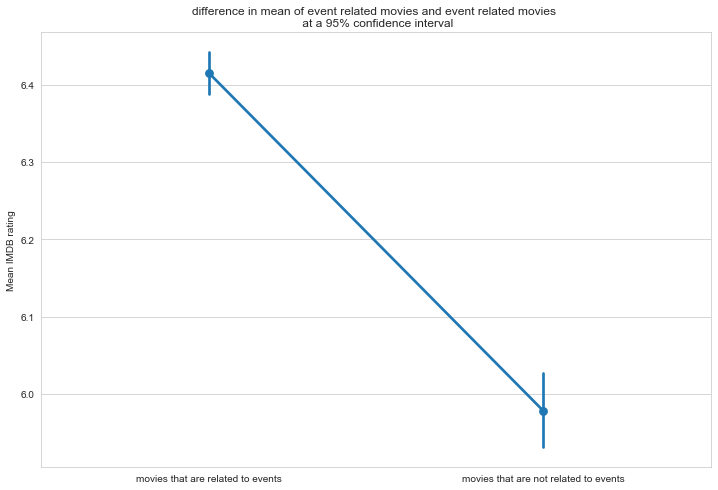

In [98]:
related_unrelated_movies = \
    pd.DataFrame({'movies that are related to events': movies_related_to_events['rating'] , 'movies that are not related to events': movies_unrelated_to_events['rating']})


plt.figure(figsize=(12, 8))
# plot the mean salary for each throwing hand
sns.pointplot(data=related_unrelated_movies, errorbar=("ci", 95))

plt.title("difference in mean of event related movies and event related movies \n at a 95% confidence interval")
plt.ylabel("Mean IMDB rating")
plt.grid(axis='y', linestyle='-')
plt.show()